# MSA 2025 Phase 2 - Part 2: Minimum Temperature Prediction from Weather Data

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns

import mlflow
import mlflow.sklearn
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 1. Load and check the dataset

### 1.1 load the data and check all the variables

In [4]:
# Get the current working directory
current_directory = os.getcwd()

# define a funcion to load the specific file
def load_data(file_name):
    file_path = os.path.join(current_directory, file_name)
    return pd.read_csv(file_path,encoding='latin1')

# define the file names
file_name= "Summary of Weather.csv"

# Load the data
df_weather = load_data(file_name)

# Display the first ten instances
print(df_weather.head(5))

     STA      Date Precip  WindGustSpd    MaxTemp    MinTemp   MeanTemp  \
0  10001  1942-7-1  1.016          NaN  25.555556  22.222222  23.888889   
1  10001  1942-7-2      0          NaN  28.888889  21.666667  25.555556   
2  10001  1942-7-3   2.54          NaN  26.111111  22.222222  24.444444   
3  10001  1942-7-4   2.54          NaN  26.666667  22.222222  24.444444   
4  10001  1942-7-5      0          NaN  26.666667  21.666667  24.444444   

  Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  SD3  RHX  RHN  \
0      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
1      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
2      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
3      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
4      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   

  RVG  WTE  
0 NaN  NaN  
1 NaN  NaN  
2 NaN  NaN  
3 NaN  NaN  
4 N

C:\Users\nvgip\AppData\Local\Temp\ipykernel_11588\2975871362.py:7: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path,encoding='latin1')


display the features and understand them

In [5]:
# Display the number of instances and features
num_instances, num_features = df_weather.shape

print(f"Number of instances: {num_instances}")
print(f"Number of features: {num_features}")

# display the features
print("Features in the dataset:")
print(df_weather.columns.tolist()) 

Number of instances: 119040
Number of features: 31
Features in the dataset:
['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']


After reviewing the documentation, I categorized the 31 features into 7 groups as follows:

1.**Identification**: STA, Date, YR, MO, DA

2.**Temperature-related**: MaxTemp, MinTemp, MeanTemp, MAX, MIN, MEA

3.**Precipitation/Snow**: Precip, PRCP, Snowfall, SNF, SND, SD3, WTE

4.**Wind-related**: WindGustSpd, DR, SPD, PGT

5.**Humidity & Visibility**: RHX, RHN, RVG

6.**Weather Conditions**: PoorWeather, TSHDSBRSGF

7.**Freezing/Ice Layer**: FT, FB, FTI, ITH

### 1.2 Missing data

Nine variables are entirely missing, and several others have over 70% missing values. Even if some are correlated with the target, their poor data quality makes imputation unreliable. These features are therefore dropped during cleaning in Section 2.

In [6]:
# Count the number of missing values in each column
missing_count = df_weather.isnull().sum()

# Calculate the missing value ratio for each column
missing_ratio = missing_count / num_instances

# Display a summary table with missing counts and ratios, sorted by ratio
print("Missing value summary:")
print(pd.DataFrame({
    "missing_count": missing_count,
    "missing_ratio": missing_ratio
}).sort_values("missing_ratio", ascending=False))

Missing value summary:
             missing_count  missing_ratio
WTE                 119040       1.000000
FT                  119040       1.000000
RVG                 119040       1.000000
FB                  119040       1.000000
RHN                 119040       1.000000
RHX                 119040       1.000000
SD3                 119040       1.000000
FTI                 119040       1.000000
ITH                 119040       1.000000
PGT                 118515       0.995590
SPD                 118508       0.995531
WindGustSpd         118508       0.995531
DR                  118507       0.995523
SND                 113477       0.953268
TSHDSBRSGF           84803       0.712391
PoorWeather          84803       0.712391
PRCP                  1932       0.016230
Snowfall              1163       0.009770
SNF                   1163       0.009770
MEA                    498       0.004183
MAX                    474       0.003982
MIN                    468       0.003931
Date       

### 1.3 Time Span and Station Reporting Summary

The output below shows that the **dataset covers 6 years, from 1940 to 1945**.

In [7]:
# convert the 'Date' column to datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'], errors='coerce')

# check the time range of the data
date_range = df_weather['Date'].min(), df_weather['Date'].max()
print(f"Date range: {date_range}")

Date range: (Timestamp('1940-01-01 00:00:00'), Timestamp('1945-12-31 00:00:00'))


A total of 159 unique weather stations reported data during the observation period. **However, the number of active stations increased over time** — from fewer than 20 in 1940 to nearly 140 by 1945.


Number of unique weather stations: 159


d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


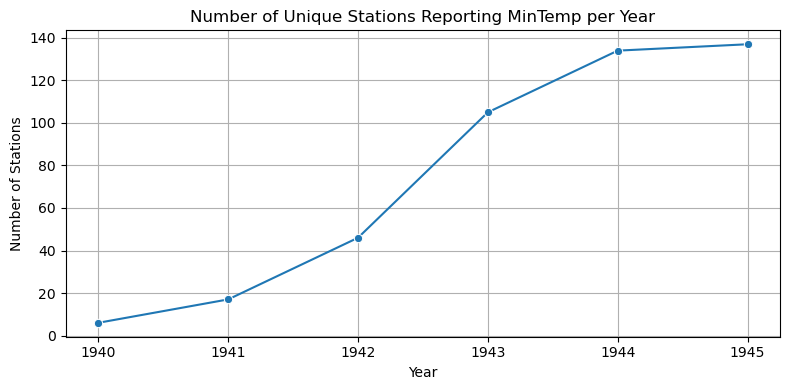

In [8]:
# check the unique values in the 'STA' column
unique_stations = df_weather['STA'].unique()
print(f"\nNumber of unique weather stations: {len(unique_stations)}")

# Ensure 'Date' column is in datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

# Extract year from the date
df_weather['Year'] = df_weather['Date'].dt.year

# Count the number of unique stations reporting per year
station_count_per_year = (
    df_weather.groupby('Year')['STA']
    .nunique()
    .reset_index()
    .rename(columns={'STA': 'Num_Stations'})
)

# Plot the number of stations per year
plt.figure(figsize=(8, 4))
sns.lineplot(data=station_count_per_year, x='Year', y='Num_Stations', marker='o')
plt.title('Number of Unique Stations Reporting MinTemp per Year')
plt.xlabel('Year')
plt.ylabel('Number of Stations')
plt.grid(True)
plt.tight_layout()
plt.show()

**while more stations contribute data each year, the volume of records per station varies widely.**  
Some stations have over 2,000 records, while 13 stations have fewer than 100. Such imbalance may introduce bias or instability into the model, especially if underrepresented stations are included in the test set.

Top 5 stations with most records:
   Station_ID  Record_Count
0       22508          2192
1       10701          2185
2       22502          2154
3       22504          2118
4       10803          1750

Bottom 5 stations with least records:
     Station_ID  Record_Count
154       42206            50
155       33123            47
156       43307            46
157       34101            31
158       33121            13


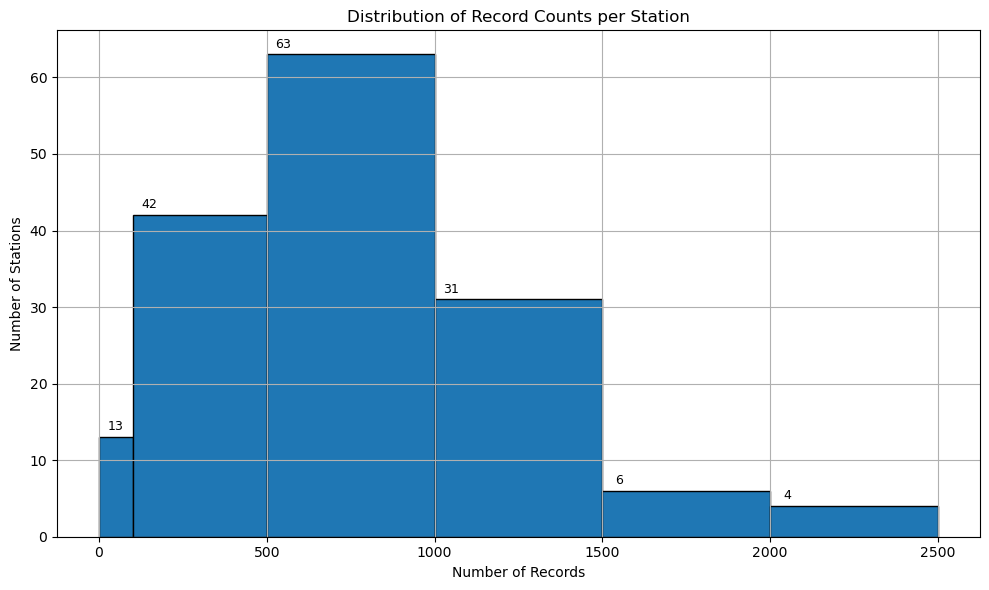

In [9]:
# ----- Summary of station records -----
# Create a DataFrame showing the number of records per station
station_counts_df = df_weather['STA'].value_counts().reset_index()
station_counts_df.columns = ['Station_ID', 'Record_Count']

# Sort the DataFrame by record count (optional, descending)
station_counts_df = station_counts_df.sort_values(by='Record_Count', ascending=False)

# display the most and least 5 stations
print("Top 5 stations with most records:")
print(station_counts_df.head(5))
print("\nBottom 5 stations with least records:")
print(station_counts_df.tail(5))


# ----- Plotting the distribution of record counts per station -----
# Extract record counts per station
record_counts = station_counts_df['Record_Count']

# Define custom bins: first bin for stations with <100 records, then 500-step bins
bins = [0, 100] + list(range(500, record_counts.max() + 500, 500))

# Create histogram
plt.figure(figsize=(10, 6))
counts, bin_edges, patches = plt.hist(record_counts, bins=bins, edgecolor='black')

# Add count labels above each bar
for count, edge in zip(counts, bin_edges[:-1]):
    if count > 0:
        # Calculate the horizontal center of the bin
        center = edge + (bin_edges[1] - bin_edges[0]) / 2
        plt.text(center, count + 0.5, str(int(count)), ha='center', va='bottom', fontsize=9)

# Add labels and title
plt.title('Distribution of Record Counts per Station')
plt.xlabel('Number of Records')
plt.ylabel('Number of Stations')
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.4 Outlier Identification

I flagged stations with suspicious `MinTemp` values based on the following conditions:
- Fixed value near `-17.777778`
- Temperatures below -20°C or above 40°C

These values likely indicate sensor errors or placeholder entries.  
 Then plotted yearly `MinTemp` trends for affected stations to visually confirm anomalies.

*Note: The fixed value `-17.777778` was discovered during initial model training and appears to be a placeholder caused by data conversion issues.*


In [10]:
"""define a function to detect abnormal values"""

def detect_abnormal_values(df, column='MinTemp', fixed_vals=[-17.777778], min_val=-20, max_val=40):
    """
    Detect abnormal values in a numeric column based on fixed placeholders and thresholds.
    
    Returns:
        DataFrame with boolean flags for each abnormal type.
    """
    df = df.copy()

    # Flag fixed placeholder values (e.g., -17.777778)
    is_fixed = np.isclose(df[column], fixed_vals[0], atol=1e-4)
    for val in fixed_vals[1:]:
        is_fixed |= np.isclose(df[column], val, atol=1e-4)

    # Flag out-of-range values
    is_low = df[column] < min_val
    is_high = df[column] > max_val

    # Combine all flags
    df['abnormal_fixed_val'] = is_fixed
    df['abnormal_low'] = is_low
    df['abnormal_high'] = is_high
    df['is_abnormal'] = is_fixed | is_low | is_high

    return df



""" Plot daily MinTemp of a given station, grouped by year (one line per year)."""

def plot_yearly_min_temp(df, station_id):
    """
    Plot daily MinTemp of a given station, grouped by year (one line per year).

    Parameters:
        df (DataFrame): The dataframe containing Date, MinTemp, STA, etc.
        station_id (int): The STA ID of the station to plot.
    """
    # Filter data for the specified station
    station_df = df[df['STA'] == station_id].copy()
    station_df['Date'] = pd.to_datetime(station_df['Date'], errors='coerce')
    station_df = station_df.sort_values('Date')

    if station_df.empty:
        print(f"No data found for station {station_id}.")
        return

    # Add year and day-of-year columns
    station_df['Year'] = station_df['Date'].dt.year
    station_df['DayOfYear'] = station_df['Date'].dt.dayofyear

    # Plot MinTemp trends by year
    plt.figure(figsize=(12, 6), facecolor='white') 
    for year, group in station_df.groupby('Year'):
        plt.plot(group['DayOfYear'], group['MinTemp'], label=str(year), alpha=0.8)

    plt.title(f'STA {station_id} - MinTemp Trends by Year')
    plt.xlabel('Day of Year')
    plt.ylabel('MinTemp (°C)')
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [11]:
# Run detection
abnormal_df = detect_abnormal_values(df_weather, column='MinTemp')

# Extract rows by category
fixed_val_rows = abnormal_df[abnormal_df['abnormal_fixed_val']]
low_val_rows = abnormal_df[abnormal_df['abnormal_low']]
high_val_rows = abnormal_df[abnormal_df['abnormal_high']]

# Collect unique station IDs
fixed_val_stations = fixed_val_rows['STA'].unique()
low_val_stations = low_val_rows['STA'].unique()
high_val_stations = high_val_rows['STA'].unique()

# Display statistics
print(f"✅ Total abnormal records: {abnormal_df['is_abnormal'].sum()}")

print(f"\n📌 Number of stations with fixed value anomalies: {len(fixed_val_stations)}")
print(f"Stations: {fixed_val_stations}")

print(f"\n📌 Number of stations with too low values (< { -20 }): {len(low_val_stations)}")
print(f"Stations: {low_val_stations}")

print(f"\n📌 Number of stations with too high values (> { 40 }): {len(high_val_stations)}")
print(f"Stations: {high_val_stations}")

✅ Total abnormal records: 844

📌 Number of stations with fixed value anomalies: 33
Stations: [10705 10803 10804 10806 11601 11901 11902 12702 12706 13002 16101 16405
 16407 16504 22502 22504 32701 32803 32904 33117 33206 33307 33401 34012
 34150 42204 42401 43302 50301 80411 81404 81702 82502]

📌 Number of stations with too low values (< -20): 4
Stations: [16405 16407 16504 44401]

📌 Number of stations with too high values (> 40): 0
Stations: []


For stations with extremely low values (MinTemp < -20°C), no obvious anomalies were observed based on line continuity. The temperature trends appear consistent over time.

Plotting yearly MinTemp trends for stations with suspect low temperture anomalies:


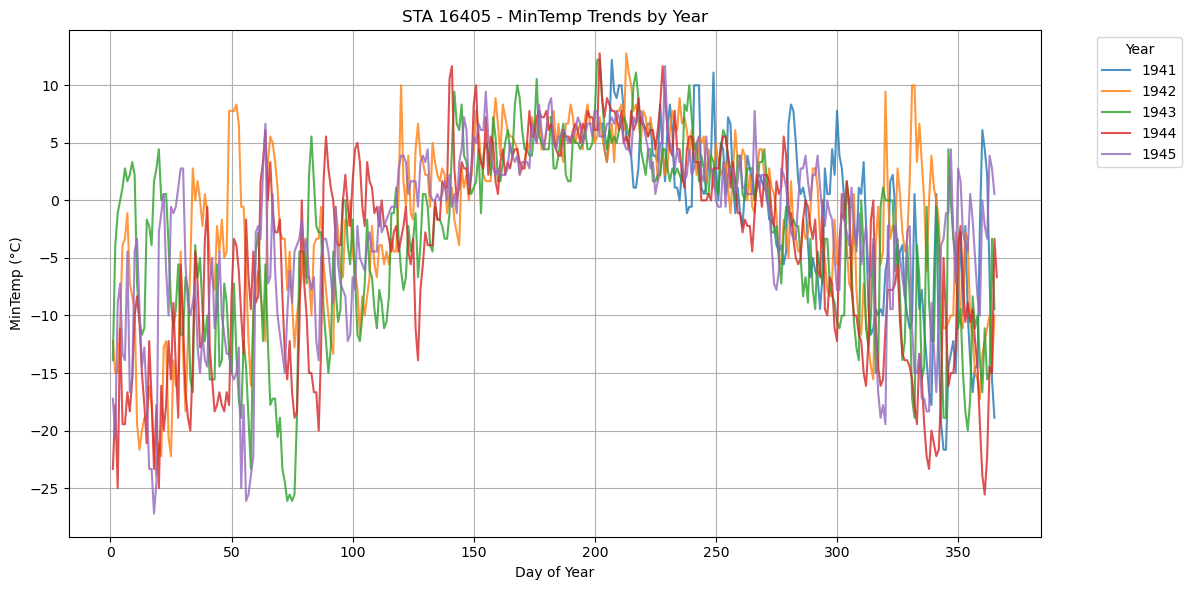

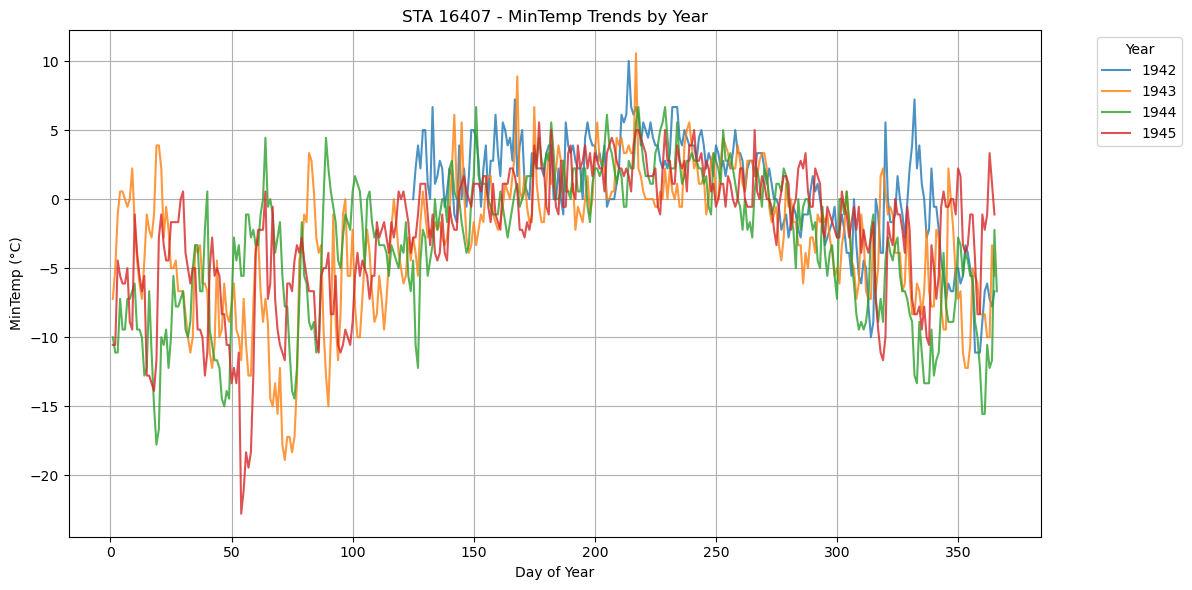

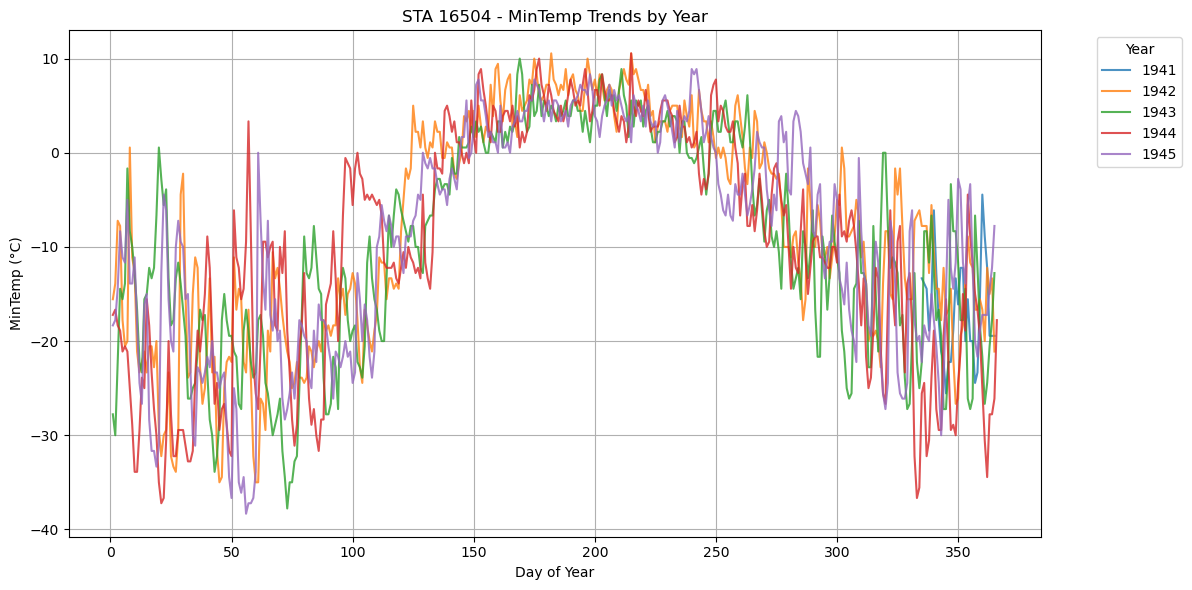

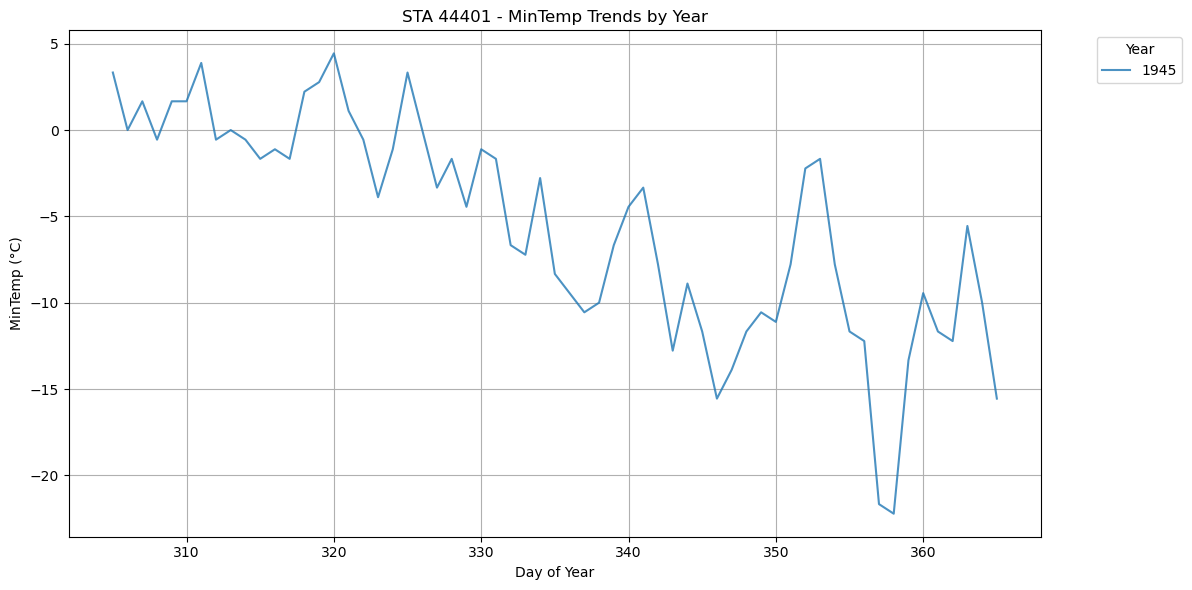

In [12]:
print("Plotting yearly MinTemp trends for stations with suspect low temperture anomalies:")
for station_id in low_val_stations:
    plot_yearly_min_temp(df_weather, station_id)

For stations with the placeholder value `-17.7778`, only 33 stations were affected.  
The most affected station had 124 such records, while the least had only 1.

In [13]:
# Create mask for values close to -17.77778
mask = np.isclose(df_weather['MinTemp'], -17.77778, atol=1e-4)
print(f"Number of records close to -17.77778: {mask.sum()}")

# Filter records with placeholder value
placeholder_df = df_weather[mask]

# Count occurrences by STA
sta_counts = placeholder_df['STA'].value_counts()

# Display most frequent 30 stations
print("\n📌 Top 30 stations with the most placeholder values:")
print(sta_counts.head(30))

Number of records close to -17.77778: 496

📌 Top 30 stations with the most placeholder values:
STA
11901    124
10705    117
10806    114
16504     25
22504     17
81404     17
11902     14
16405     13
33206     11
32803      5
34012      3
32904      3
42204      3
16101      3
22502      2
10803      2
16407      2
12706      2
33307      2
50301      2
12702      2
11601      2
42401      1
81702      1
80411      1
43302      1
32701      1
34150      1
33401      1
33117      1
Name: count, dtype: int64


After plotting, some stations with only 1–2 occurrences of `-17.7778` still showed clearly abnormal behavior — the `MinTemp` on those dates was significantly lower than surrounding days.  
Therefore, these values were also treated as invalid and cleaned during the following preprocessing stage.

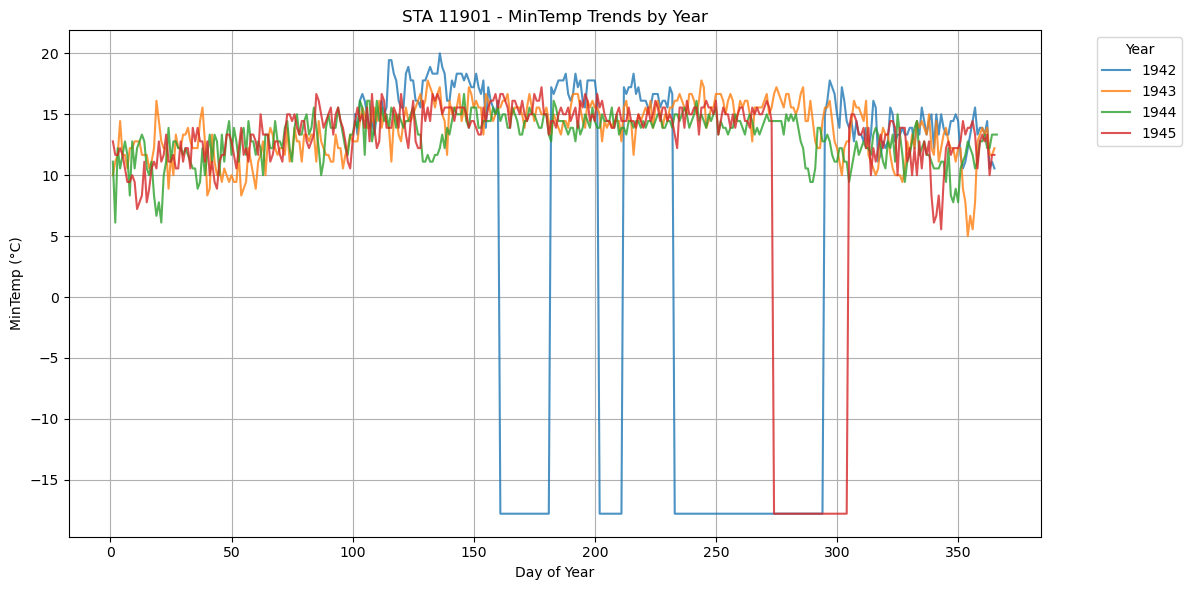

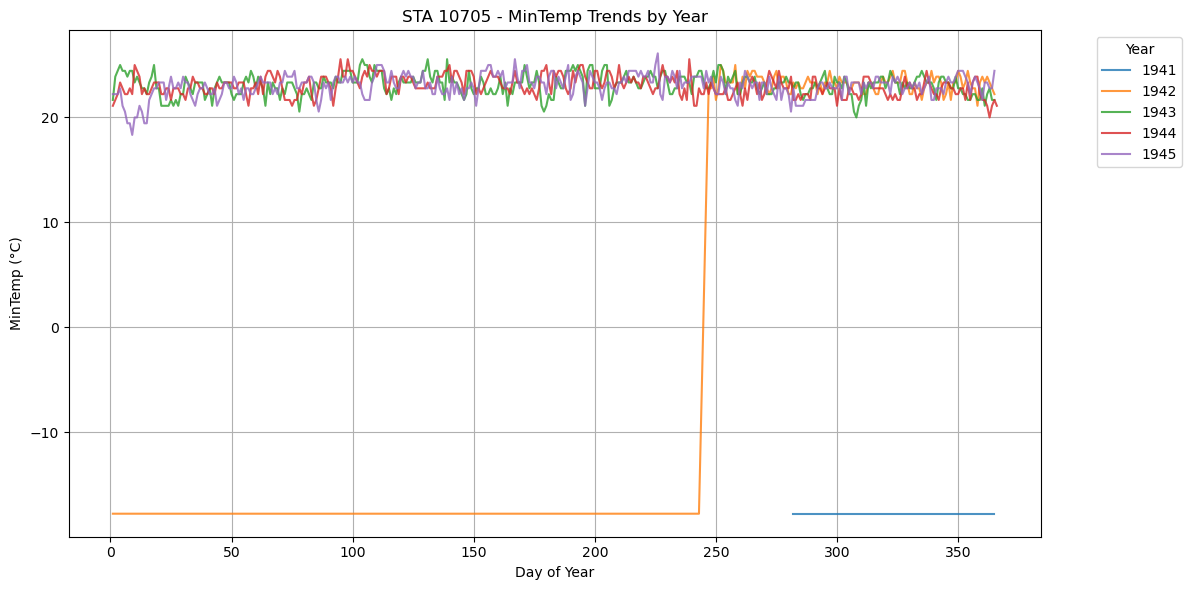

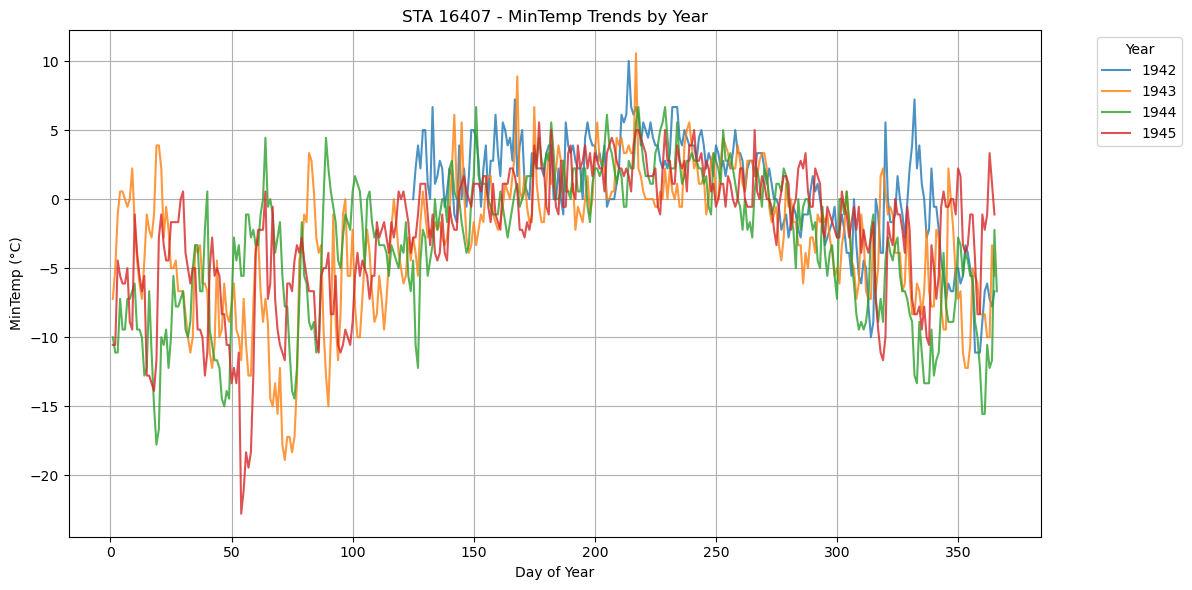

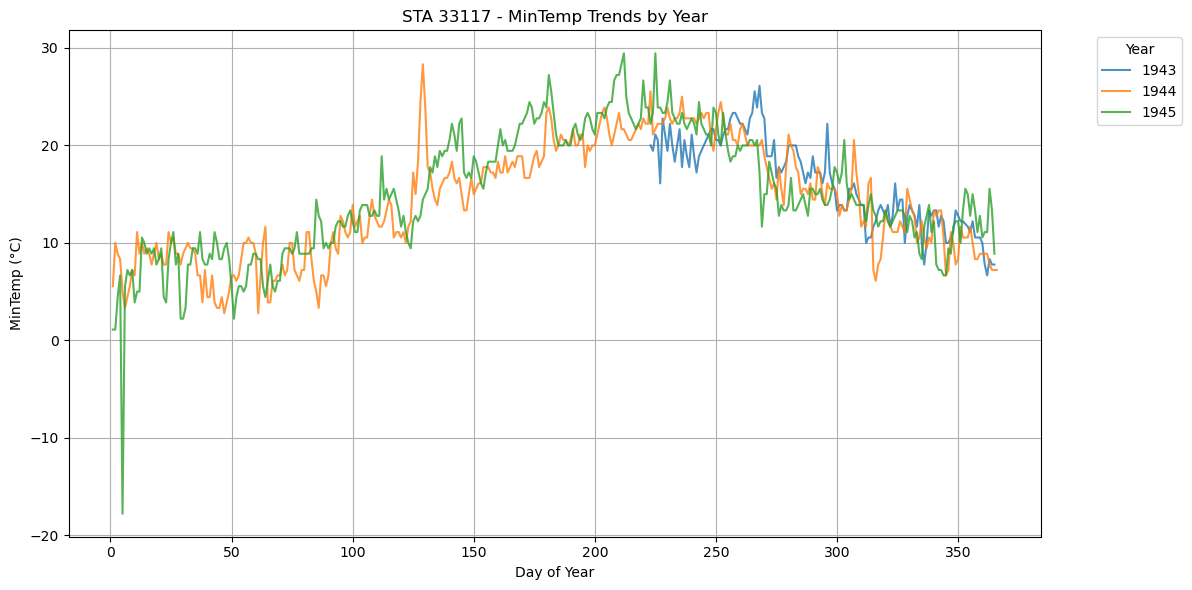

In [14]:
# define a list of station IDs to plot
id_list = [11901, 10705, 16407, 33117]
for station_id in id_list:
    plot_yearly_min_temp(df_weather, station_id)

## 2. Clean the dataset, drop variables

In this step, only retained columns with less than 30% missing values and handled detected outliers accordingly.

### 2.1 Drop highly missing columns

In [15]:
# Define the missing value threshold
threshold = 0.7

# Identify columns with missing ratio greater than the threshold
cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()

# Print the list of columns to be dropped
print(f"\nColumns to drop (missing_ratio > {threshold*100:.0f}%): {cols_to_drop}")

# Drop the identified columns and create a cleaned DataFrame
df_weather_clean= df_weather.drop(columns=cols_to_drop)


Columns to drop (missing_ratio > 70%): ['WindGustSpd', 'PoorWeather', 'DR', 'SPD', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']


### 2.2 Handle Outliers from Section 1.4

Number of records close to -17.77778: 496
Data after replacing -17.77778 with NaN


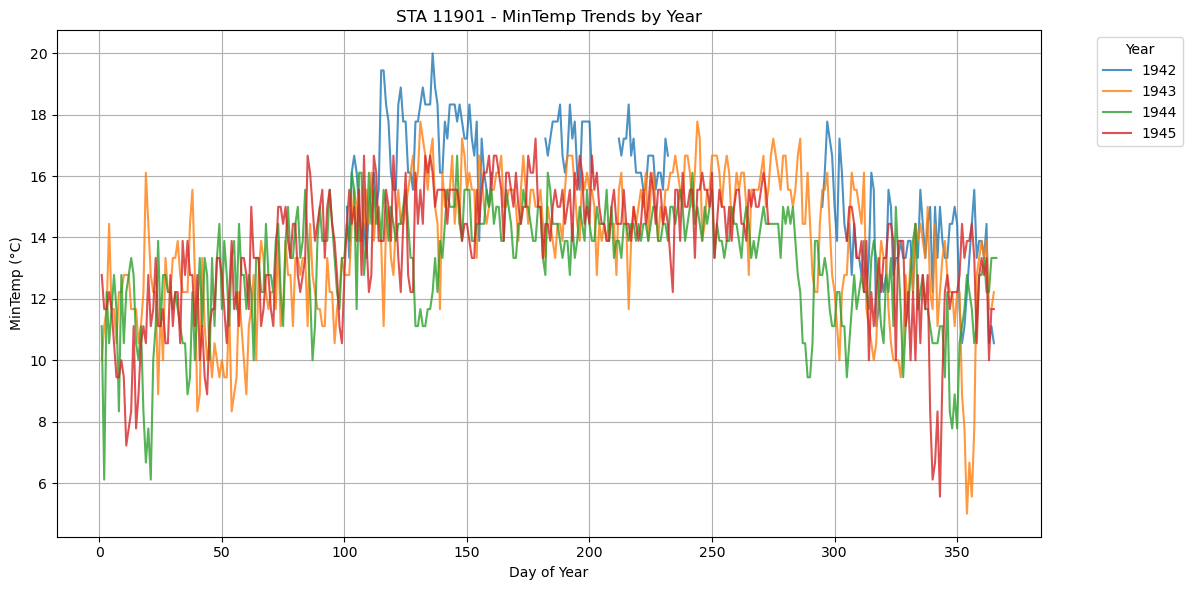

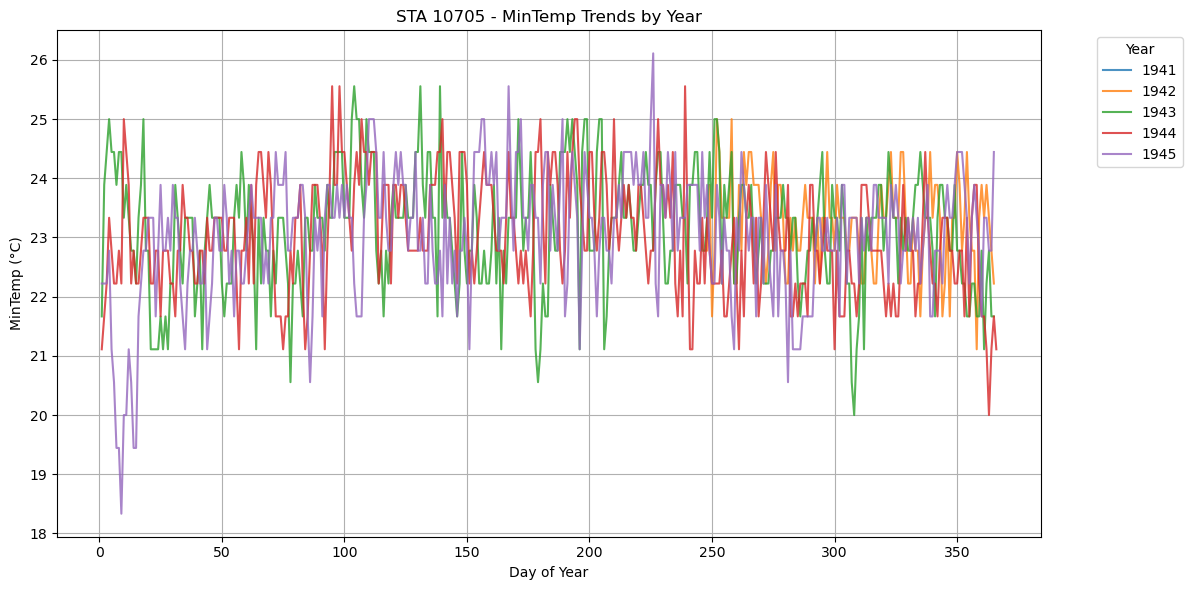

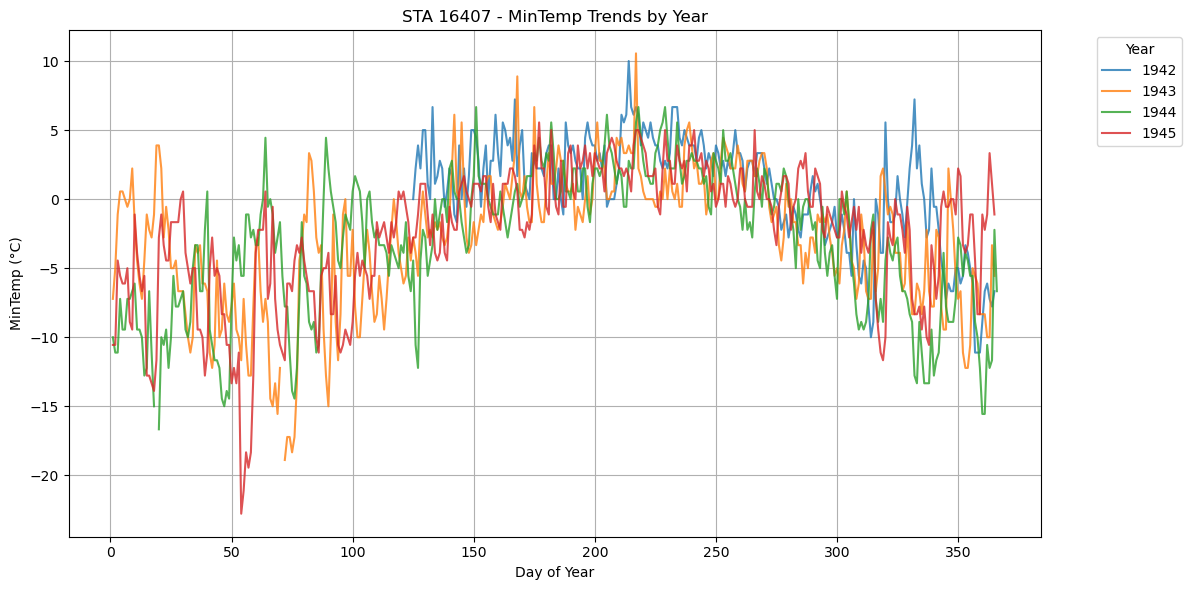

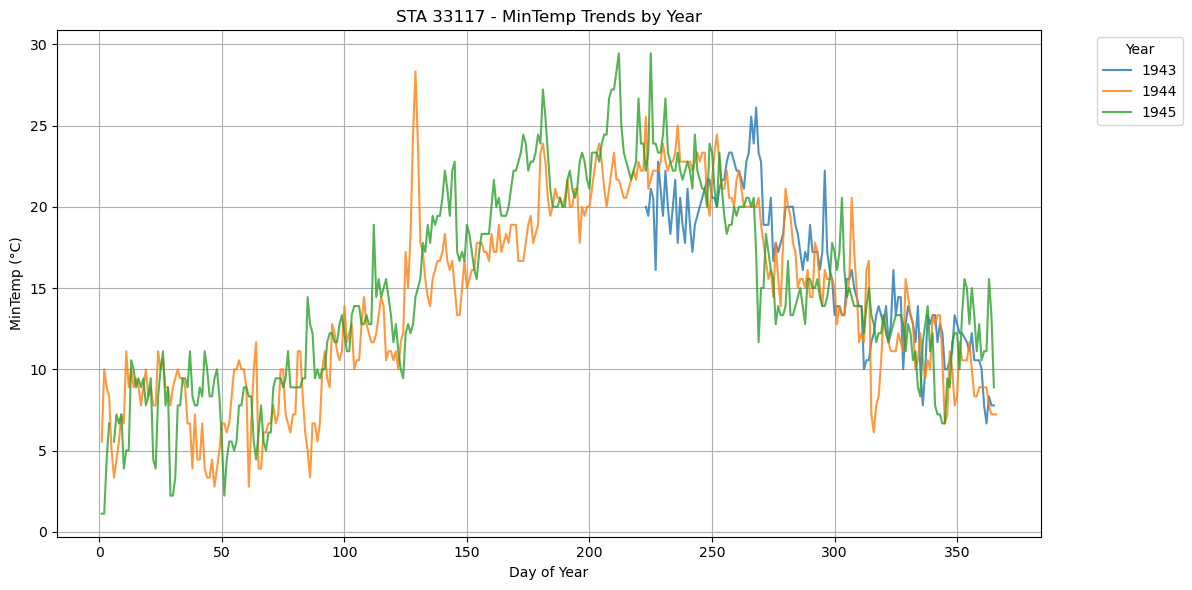

In [16]:
# Identify values in MinTemp that are very close to -17.77778
mask = np.isclose(df_weather_clean['MinTemp'], -17.77778, atol=1e-4)
print(f"Number of records close to -17.77778: {mask.sum()}")

# Preview affected records
df_weather_clean[mask][['Date', 'STA', 'MinTemp']].head(20)

# Replace placeholder values with NaN to mark as missing
df_weather_clean['MinTemp'] = df_weather_clean['MinTemp'].mask(
    np.isclose(df_weather_clean['MinTemp'], -17.77778, atol=1e-4), 
    np.nan
)

print("Data after replacing -17.77778 with NaN")


for list in id_list:
    plot_yearly_min_temp(df_weather_clean, list)

### ？：then 

In [17]:
# Try converting all object columns to float if possible
object_cols = df_weather_clean.select_dtypes(include='object').columns

for col in object_cols:
    try:
        df_weather_clean[col] = pd.to_numeric(df_weather_clean[col])
        print(f"Converted {col} to numeric.")
    except:
        print(f"⚠️ Column {col} is non-numeric and remains object.")




# check the type of columns in the cleaned DataFrame
print("\nData types of columns in the cleaned DataFrame:")
print(df_weather_clean.dtypes)

⚠️ Column Precip is non-numeric and remains object.
⚠️ Column Snowfall is non-numeric and remains object.
⚠️ Column PRCP is non-numeric and remains object.
⚠️ Column SNF is non-numeric and remains object.

Data types of columns in the cleaned DataFrame:
STA                  int64
Date        datetime64[ns]
Precip              object
MaxTemp            float64
MinTemp            float64
MeanTemp           float64
Snowfall            object
YR                   int64
MO                   int64
DA                   int64
PRCP                object
MAX                float64
MIN                float64
MEA                float64
SNF                 object
Year                 int32
dtype: object


## 3. Select the feature(s) for the model, and explain the reason

### 3.1 Drop columns not needed for modelling

- **'MaxTemp'** and **'MeanTemp'** are dropped because they are strongly correlated with 'MinTemp'  and could cause target leakage if they reflect future or same-day temperature summaries.
- **'MAX'**, **'MIN'**, and **'MEA'** are Fahrenheit versions of the temperature and are redundant since we are predicting Celsius values; they are therefore removed.
- drop **YR MO DA** in case of wrong data, generate time related features at next step

In [18]:
# Define the features to drop
features_to_drop = ['MaxTemp', 'MeanTemp', 'MAX', 'MIN', 'MEA','YR','MO','DA']  

# Drop the specified features
df_weather_feat_selected = df_weather_clean.drop(columns=features_to_drop)

# Display the first few rows of the cleaned DataFrame
print("\nFirst few rows of the cleaned DataFrame after dropping specified features:")
print(df_weather_feat_selected.head())


First few rows of the cleaned DataFrame after dropping specified features:
     STA       Date Precip    MinTemp Snowfall  PRCP  SNF  Year
0  10001 1942-07-01  1.016  22.222222      0.0  0.04  0.0  1942
1  10001 1942-07-02      0  21.666667      0.0     0  0.0  1942
2  10001 1942-07-03   2.54  22.222222      0.0   0.1  0.0  1942
3  10001 1942-07-04   2.54  22.222222      0.0   0.1  0.0  1942
4  10001 1942-07-05      0  21.666667      0.0     0  0.0  1942


### 3.2 create time related features

Temperature is a time series variable with strong seasonal patterns. Creating time-related features can help the model better capture its periodic behavior.

First, generate the features year, season, and month.

In [19]:
# Ensure 'Date' column is in datetime format
df_weather_feat_selected['Date'] = pd.to_datetime(df_weather_feat_selected['Date'])

# # Extract day of year (1–365/366)
# df_weather_feat_selected['day_of_year'] = df_weather_feat_selected['Date'].dt.dayofyear

# Extract month (1–12)
df_weather_feat_selected['month'] = df_weather_feat_selected['Date'].dt.month

# Extract year
df_weather_feat_selected['year'] = df_weather_feat_selected['Date'].dt.year

# Define a function to assign seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

# Apply the season function
df_weather_feat_selected['season'] = df_weather_feat_selected['month'].apply(get_season)

Then, generate sine and cosine features of day_of_year, using the number of days in each year as the cycle length.

In [20]:
# Detect if each date is in a leap year
df_weather_feat_selected['is_leap_year'] = df_weather_feat_selected['Date'].dt.is_leap_year

# Extract day of year
df_weather_feat_selected['day_of_year'] = df_weather_feat_selected['Date'].dt.dayofyear

# Assign the correct number of days in each year (365 or 366)
df_weather_feat_selected['days_in_year'] = df_weather_feat_selected['is_leap_year'].apply(lambda x: 366 if x else 365)

# Compute sine and cosine transformations of day_of_year based on each year's actual length
df_weather_feat_selected['sin_doy'] = np.sin(2 * np.pi * df_weather_feat_selected['day_of_year'] / df_weather_feat_selected['days_in_year'])
df_weather_feat_selected['cos_doy'] = np.cos(2 * np.pi * df_weather_feat_selected['day_of_year'] / df_weather_feat_selected['days_in_year'])

# Drop the 'day_of_year' and 'days_in_year'
df_weather_feat_selected.drop(columns=['day_of_year', 'days_in_year','is_leap_year'], inplace=True)

# Display the first few rows of the DataFrame with new time-related features
print("\nFirst few rows of the DataFrame with new time-related features:")
print(df_weather_feat_selected.head())


First few rows of the DataFrame with new time-related features:
     STA       Date Precip    MinTemp Snowfall  PRCP  SNF  Year  month  year  \
0  10001 1942-07-01  1.016  22.222222      0.0  0.04  0.0  1942      7  1942   
1  10001 1942-07-02      0  21.666667      0.0     0  0.0  1942      7  1942   
2  10001 1942-07-03   2.54  22.222222      0.0   0.1  0.0  1942      7  1942   
3  10001 1942-07-04   2.54  22.222222      0.0   0.1  0.0  1942      7  1942   
4  10001 1942-07-05      0  21.666667      0.0     0  0.0  1942      7  1942   

   season   sin_doy   cos_doy  
0       2  0.008607 -0.999963  
1       2 -0.008607 -0.999963  
2       2 -0.025818 -0.999667  
3       2 -0.043022 -0.999074  
4       2 -0.060213 -0.998186  


In [21]:
# checke the type of columns in the DataFrame
print("\nData types of columns in the DataFrame with new features:")
print(df_weather_feat_selected.dtypes)


Data types of columns in the DataFrame with new features:
STA                  int64
Date        datetime64[ns]
Precip              object
MinTemp            float64
Snowfall            object
PRCP                object
SNF                 object
Year                 int32
month                int32
year                 int32
season               int64
sin_doy            float64
cos_doy            float64
dtype: object


### 3.3 features correlation analysis

Pearson correlation analysis helps reveal relationships between variables.  

On one hand, it identifies features that are strongly correlated with the target variable and should be retained for modeling.  

On the other hand, it highlights highly interdependent features, allowing us to remove redundant ones and reduce multicollinearity.

In [22]:
# See all unique non-numeric values in object columns
for col in ['Precip', 'Snowfall', 'PRCP', 'SNF']:
    print(f"\n❓ Unique values in {col} that are non-numeric:")
    non_numeric_mask = pd.to_numeric(df_weather_feat_selected[col], errors='coerce').isna() & df_weather_feat_selected[col].notna()
    print(df_weather_feat_selected.loc[non_numeric_mask, col].unique())


❓ Unique values in Precip that are non-numeric:
['T']

❓ Unique values in Snowfall that are non-numeric:
['#VALUE!']

❓ Unique values in PRCP that are non-numeric:
['T']

❓ Unique values in SNF that are non-numeric:
['T']


In [23]:
# Define a cleaning function for weather fields
def clean_weather_column(col):
    return col.replace({'T': 0.001, '#VALUE!': np.nan}).astype(float)

# Apply to relevant columns
for col in ['Precip', 'Snowfall', 'PRCP', 'SNF']:
    df_weather_feat_selected[col] = clean_weather_column(df_weather_feat_selected[col])

# Confirm types
print(df_weather_feat_selected.dtypes)


STA                  int64
Date        datetime64[ns]
Precip             float64
MinTemp            float64
Snowfall           float64
PRCP               float64
SNF                float64
Year                 int32
month                int32
year                 int32
season               int64
sin_doy            float64
cos_doy            float64
dtype: object


The heatmap below shows that Precip and PRCP, as well as Snowfall and SNF, day_of_year and month are perfectly correlated (r = 1), indicating they represent the same variables. We retain the ones with fewer missing values—Precip and Snowfall (see Section 1.2).

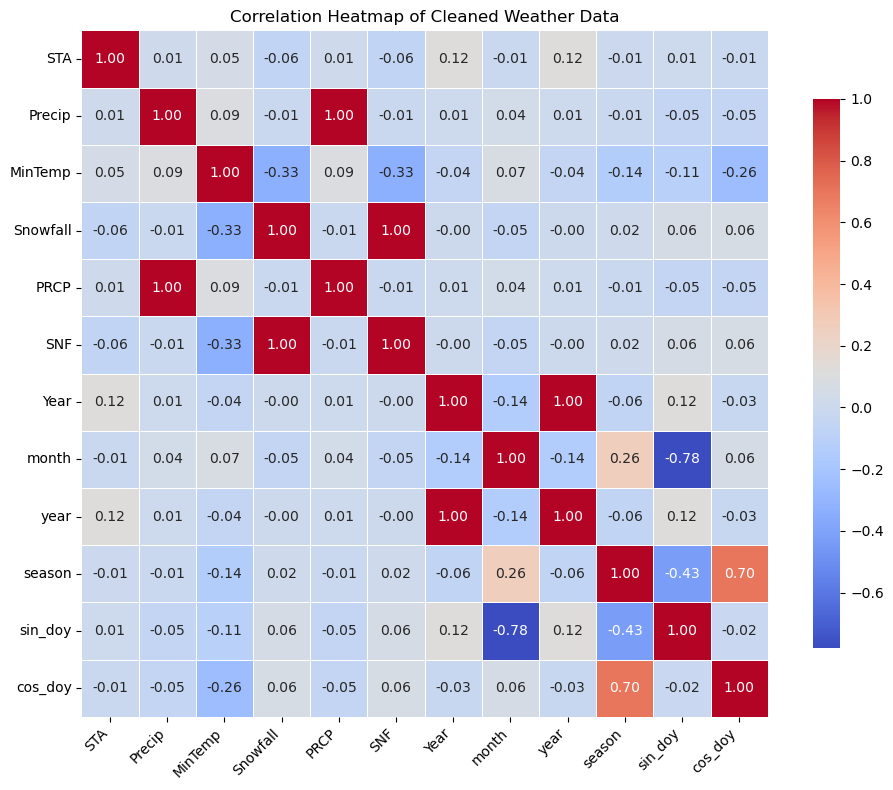

In [24]:
# Compute the correlation matrix
correlation_matrix = df_weather_feat_selected.select_dtypes(include='number').corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": 0.8}, linewidths=0.5)

plt.title("Correlation Heatmap of Cleaned Weather Data")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [25]:
# drop the highly correlated features
features_to_drop = ['SNF', 'PRCP']

df_weather_final = df_weather_feat_selected.drop(columns=features_to_drop)

# Display the final DataFrame
print("\nFinal DataFrame after dropping highly correlated features:")
print(df_weather_final.head())


Final DataFrame after dropping highly correlated features:
     STA       Date  Precip    MinTemp  Snowfall  Year  month  year  season  \
0  10001 1942-07-01   1.016  22.222222       0.0  1942      7  1942       2   
1  10001 1942-07-02   0.000  21.666667       0.0  1942      7  1942       2   
2  10001 1942-07-03   2.540  22.222222       0.0  1942      7  1942       2   
3  10001 1942-07-04   2.540  22.222222       0.0  1942      7  1942       2   
4  10001 1942-07-05   0.000  21.666667       0.0  1942      7  1942       2   

    sin_doy   cos_doy  
0  0.008607 -0.999963  
1 -0.008607 -0.999963  
2 -0.025818 -0.999667  
3 -0.043022 -0.999074  
4 -0.060213 -0.998186  


## 4. Split the dataset (80% for training, 20% for testing)

To address the imbalance in record counts across stations, only stations with at least 100 records were retained, preserving 99.32% of the data. 

The remaining data was sorted chronologically, with the first 80% used for training and the last 20% for testing, ensuring no future data leakage and aligning with real-world forecasting scenarios.

In [26]:
station_threshold = 100  # Minimum number of records per station

# Ensure date is in datetime format
df_weather_final['Date'] = pd.to_datetime(df_weather_final['Date'])

# Step 1: Keep only stations with at least 365 records
station_counts = df_weather_final['STA'].value_counts()
print(f"Number of stations before filtering: {len(station_counts)}")
valid_stations = station_counts[station_counts >= station_threshold].index

df_filtered = df_weather_final[df_weather_final['STA'].isin(valid_stations)].copy()

# Print percentage of remaining records
ratio = len(df_filtered) / len(df_weather_final)
print(f'Filtered records: {len(df_filtered)} / {len(df_weather_final)} ({ratio:.2%})')

# Step 2: Sort by date and calculate 80% split point
df_filtered = df_filtered.sort_values('Date')
split_date = df_filtered['Date'].quantile(0.8)

# Step 3: Split into train and test sets
train_df = df_filtered[df_filtered['Date'] <= split_date]
test_df  = df_filtered[df_filtered['Date'] > split_date]

# Step 4: Check station coverage in both sets
train_stations = set(train_df['STA'].unique())
test_stations = set(test_df['STA'].unique())
common_stations = train_stations.intersection(test_stations)

print(f'Total stations in train: {len(train_stations)}')
print(f'Total stations in test : {len(test_stations)}')
print(f'Stations in both        : {len(common_stations)}')

# Step 5: Because of using lag features, include one extra day for test context
lag_start_date = test_df['Date'].min() - pd.Timedelta(days=1)
extra_lag_row = df_filtered[df_filtered['Date'] == lag_start_date]
train_df = pd.concat([train_df, extra_lag_row])


# filter station in test but not in train
test_stations = set(test_df['STA'].unique())

only_test_stations = []
for station in test_stations:
    if station not in train_stations:

        only_test_stations.append(station)

print(f"Stations only in test: {only_test_stations}")

Number of stations before filtering: 159
Filtered records: 118236 / 119040 (99.32%)
Total stations in train: 144
Total stations in test : 123
Stations in both        : 121
Stations only in test: [13013, 34017]


In [27]:
# Check unprocessed NaN in test_df
print("test_df missing values before prediction:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

test_df missing values before prediction:
MinTemp      50
Snowfall    148
dtype: int64


Now Fill remaining NaNs

In [ ]:
# Step 1: Fill by STA + year + month
monthly_means = test_df.groupby(['STA', 'year', 'month'])[['MinTemp', 'Snowfall']].mean().reset_index()
test_df = test_df.merge(monthly_means, on=['STA', 'year', 'month'], how='left', suffixes=('', '_mean'))

for col in ['MinTemp', 'Snowfall']:
    test_df[col] = test_df[col].fillna(test_df[f'{col}_mean'])
    test_df.drop(columns=[f'{col}_mean'], inplace=True)

# Step 2: Fill remaining NaNs by STA + year_mean
yearly_means = test_df.groupby(['STA', 'year'])[['MinTemp', 'Snowfall']].mean().reset_index()
test_df = test_df.merge(yearly_means, on=['STA', 'year'], how='left', suffixes=('', '_year_mean'))

for col in ['MinTemp', 'Snowfall']:
    test_df[col] = test_df[col].fillna(test_df[f'{col}_year_mean'])
    test_df.drop(columns=[f'{col}_year_mean'], inplace=True)

# Step 3: Fill remaining NaNs by overall mean
for col in ['MinTemp', 'Snowfall']:
    test_df[col] = test_df[col].fillna(test_df[col].mean())

In [29]:
# Check unprocessed NaN in test_df
print("test_df missing values before prediction:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

test_df missing values before prediction:
Series([], dtype: int64)


## 5. Choose the algorithm, train and test the model

First, train and test the model using XGBoost, while recording the parameter settings and corresponding outputs with MLflow's mlruns.

In [30]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

# ========================
# Step 1: Feature Setup
# ========================
target = 'MinTemp'
drop_cols = [target, 'Date','year']
feature_cols = [col for col in train_df.columns if col not in drop_cols]

X_train = train_df[feature_cols].copy()
y_train = train_df[target].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[target].copy()

# Separate categorical and numerical features
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Ensure categorical columns are string type
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

# Drop NaNs in y_train
not_nan_mask = ~y_train.isna()
X_train = X_train[not_nan_mask]
y_train = y_train[not_nan_mask]

# ========================
# Step 2: Model Definition
# ========================
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgb', xgb_model)
])

# ========================
# Step 3: Train & Log with MLflow
# ========================
mlflow.end_run()
with mlflow.start_run():
    # Log hyperparameters
    for param in ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree']:
        mlflow.log_param(param, xgb_model.get_params()[param])

    mlflow.log_param("station_threshold", station_threshold)
    mlflow.log_param("n_valid_stations", len(valid_stations))
    mlflow.log_param("n_records_filtered", len(df_filtered))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    mlflow.set_tag("data_split_strategy", f"date_quantile_80%, split_date={split_date.date()}")

    # Fit & predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Extract booster and feature names
    booster = model.named_steps['xgb']
    importances = booster.feature_importances_

    try:
        ohe = model.named_steps['preprocess'].named_transformers_['cat']
        cat_feature_names = ohe.get_feature_names_out(cat_cols)
        final_feature_names = num_cols + list(cat_feature_names)
    except:
        final_feature_names = num_cols + cat_cols

    # Create and log feature importance
    fi_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False)

    for i in range(min(5, len(fi_df))):
        mlflow.log_param(f"Top_{i+1}_Feature", fi_df.iloc[i]['Feature'])
        mlflow.log_metric(f"Top_{i+1}_Importance", fi_df.iloc[i]['Importance'])

    # SHAP importance
    X_train_transformed = model.named_steps['preprocess'].transform(X_train)
    explainer = shap.Explainer(booster)
    shap_values = explainer(X_train_transformed)
    shap_importance = np.abs(shap_values.values).mean(axis=0)

    shap_df = pd.DataFrame({'Feature': final_feature_names, 'SHAP_Importance': shap_importance})
    shap_df = shap_df.sort_values(by='SHAP_Importance', ascending=False)

    print("\nTop SHAP Features:")
    print(shap_df.head(10))

    for i in range(min(5, len(shap_df))):
        mlflow.log_param(f"Top_{i+1}_SHAP_Feature", shap_df.iloc[i]['Feature'])
        mlflow.log_metric(f"Top_{i+1}_SHAP_Importance", shap_df.iloc[i]['SHAP_Importance'])

    # Log model
    mlflow.sklearn.log_model(model, artifact_path="xgb_model")

    print(f"Logged to MLflow. RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.4f}")


2025/07/23 14:43:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Top SHAP Features:
    Feature  SHAP_Importance
0       STA         4.535219
7   cos_doy         1.312899
2  Snowfall         0.760200
6   sin_doy         0.423838
4     month         0.321562
5    season         0.283192
1    Precip         0.228563
3      Year         0.129106


2025/07/23 14:44:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged to MLflow. RMSE=2.271, MAE=1.638, R2=0.8855


From the above, the model's performance on the test set is as follows: RMSE = 2.271, MAE = 1.678, R² = 0.826.

Next, hyperparameter optimization is conducted using Optuna. To ensure robust tuning and prevent overfitting to a single validation set, 3-fold cross-validation is applied during the optimization process. This helps avoid data leakage and ensures that performance metrics reflect the model’s generalization ability on unseen training splits.

The best hyperparameters and the corresponding performance are as follows:

In [31]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Define Optuna objective with CV
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0),
        'random_state': 42,
        'n_jobs': -1
    }

    # Define model and pipeline
    xgb_model = xgb.XGBRegressor(**params)
    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('xgb', xgb_model)
    ])

    # Perform 3-fold CV
    rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer)

    return -scores.mean()  # negate because Optuna minimizes

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best parameters found:")
print(study.best_params)

[I 2025-07-23 14:44:01,252] A new study created in memory with name: no-name-9bb00757-5494-4558-a810-fbc4b71e45db
[I 2025-07-23 14:44:04,106] Trial 0 finished with value: 2.5534602462470057 and parameters: {'n_estimators': 764, 'max_depth': 10, 'learning_rate': 0.11673353976082058, 'subsample': 0.9839687984604971, 'colsample_bytree': 0.789496141819839, 'min_child_weight': 3, 'gamma': 3.606387300507751, 'reg_alpha': 0.19317797001091885, 'reg_lambda': 8.790728423884046}. Best is trial 0 with value: 2.5534602462470057.
[I 2025-07-23 14:44:05,178] Trial 1 finished with value: 2.7273231931373316 and parameters: {'n_estimators': 271, 'max_depth': 4, 'learning_rate': 0.16623912663730941, 'subsample': 0.8078975603899913, 'colsample_bytree': 0.5511925212698912, 'min_child_weight': 4, 'gamma': 4.8446826806797345, 'reg_alpha': 0.4863768133788774, 'reg_lambda': 0.7210397091905782}. Best is trial 0 with value: 2.5534602462470057.
[I 2025-07-23 14:44:08,850] Trial 2 finished with value: 2.5509828598

Best parameters found:
{'n_estimators': 342, 'max_depth': 8, 'learning_rate': 0.0394301982448139, 'subsample': 0.6934974688835511, 'colsample_bytree': 0.8081143472676959, 'min_child_weight': 3, 'gamma': 2.501898284315911, 'reg_alpha': 0.7428394751162073, 'reg_lambda': 6.878791698160276}


In [32]:
# Use best parameters from Optuna
best_params = study.best_params
best_params.update({
    'random_state': 42,
    'n_jobs': -1
})

# Build final model with best parameters
xgb_model = xgb.XGBRegressor(**best_params)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgb', xgb_model)
])

# Fit and evaluate as before
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Create a DataFrame to hold results
results_df = test_df.copy()  # include all test data
results_df = results_df.reset_index(drop=True)  # make sure indices align
results_df['Pred_MinTemp'] = y_pred  # add predictions

# Only keep relevant columns
results_df = results_df[['STA', 'Date', 'MinTemp', 'Pred_MinTemp']]

# Display the first few rows
print(results_df.head())


     STA       Date    MinTemp  Pred_MinTemp
0  50304 1945-05-01  23.333333     22.403933
1  32812 1945-05-01  23.888889     24.716509
2  34104 1945-05-01   9.444444      9.804065
3  42401 1945-05-01  18.888889     21.721746
4  13002 1945-05-01  15.000000     14.678935


## 6. Evaluate and Visualize model Performance

The predicted vs actual scatter plot shows that the XGBoost model performs well, with most predictions closely aligned with the actual values along the diagonal. While there is some spread in extreme low-temperature cases, the overall fit is strong, consistent with an R² of 0.90.

Model Performance on Test Set:
  RMSE: 2.1056
  MAE : 1.4886
  R²  : 0.9016


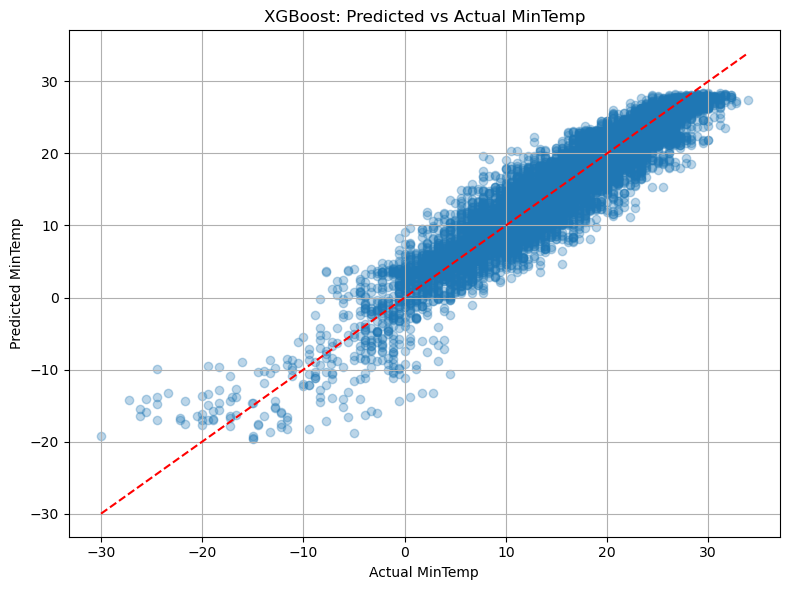

In [33]:
# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE : {mae:.4f}")
print(f"  R²  : {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MinTemp')
plt.ylabel('Predicted MinTemp')
plt.title('XGBoost: Predicted vs Actual MinTemp')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. What is the R² value and RMSE of the model? How these values indicate the model performance?

RMSE = 2.1056 means that, on average, the model’s predictions deviate from the actual values by approximately 2.1°C. A lower RMSE indicates better predictive accuracy.

R² = 0.90 suggests that the model explains 90% of the variance in the target variable. This is a strong result, indicating that the model effectively captures the key patterns in the data.

Overall, the combination of a low RMSE and a high R² reflects a well-performing model that not only makes accurate predictions but also generalizes well across the dataset.

## 8. Discuss the model performance based on the plot

Overall, the plot indicates that the model performs well, with high predictive accuracy across most temperature ranges. The alignment with the diagonal line confirms a strong correlation between actual and predicted values, consistent with the reported R² of 0.90 and RMSE of 2.1.

**Strong alignment along the diagonal**:
Most data points cluster closely around the red line, indicating that the model is accurately predicting minimum temperatures in the majority of cases.

**High density in mid-temperature ranges**:
The densest region appears between 0°C and 25°C, where predictions are tightly aligned with actual values. This suggests the model performs especially well in typical temperature ranges.

**Wider spread at the extremes**:
At very low temperatures (e.g., below -10°C), the spread increases, and predictions tend to underestimate or overestimate the true value. This is common when extreme values are underrepresented in the training data or inherently noisier.

**No major systematic bias**:
There's no strong visual evidence of consistent overprediction or underprediction, which supports the reliability of the model’s generalization.